# Analisando e priorizando falhas de cobertura em Redes de Telefonia Móvel com Machine Learning

Uma atividade de grande importância para as operadoras é analisar e priorizar regiões com falhas de cobertura. Para se ter uma idéia, na indústria de telefonia móvel, aproximadamente 10% das reclamações dos usuários estão relacionadas à qualidade, funcionamento e reparo(1).

A análise das regiões com nível de sinal ruim costuma ser feita por um engenheiro de telecomunicações que, através de um mapa de cobertura, analisa visualmente pontos ou regiões com falha.

Essa abordagem pode ser efetiva quando feita em um bairro ou numa pequena região, porém pode se tornar inviável quando feita em regiões maiores. O crescimento do tráfego de dados nas redes móveis, juntamente com a quantidade de elementos de diferentes tecnologias (2G/3G/4G), torna essa análise ainda mais complexa. O intuito desse artigo é oferecer, através de um protótipo, um método auxiliar à metodologia de inspeção visual.

<img src="image/france_pred.jpg" width="500">Simulação de cobertura 4G em escala de país, França(2)

### Primeiramente, o que é uma falha de cobertura?
Mesmo quando não está sendo utilizado (modo idle), o móvel fica medindo o tempo todo o nível de sinal que ele recebe das estações radiobase (ERB). Podemos ver uma representação gráfica dessa medida através das barrinhas do celular. 
<img src="image/level.jpg">

O que na realidade o móvel está medindo é a potência recebida. Existem vários fatores que podem afetar a qualidade do serviço, mas olhando apenas a variável nivel de sinal, podemos dizer que quanto menor a potência recebida, pior o serviço. Temos abaixo, uma tabela de exemplo, relacionando a potência à qualidade do sinal(3):
<img src="image/signal_strength_umts.jpg" width="400"/>
<p align="center">
RSSI - Received Signal Strength Indicator(4).
</p>

De uma maneira bem simplificada, um sinal ruim é um nível de sinal recebido pelo celular que não atende ou atende de maneira precária, aos requisitos mínimos de uma boa comunicação com a rede. Esse nível de sinal pobre resultará em uma experiência ruim pelo usuário.

Portanto podemos dizer que **uma região com falha de cobertura é um lugar (cluster) que apresente intensidade de sinal pobre ou inexistente**. Veja no exemplo abaixo, retirado do site TIM Portas Abertas(5), alguns locais com falhas de cobertura, circulados em vermelho:
<img src="image/coverage_fail1.1.png">
**Legenda:**  
**Azul Escuro** - Cobertura Total  
**Azul Claro** - Cobertura Parcial  
**Branco** - Sem Cobertura

Dado que os locais com falha possuem coordenadas de latitude e longitude, fica fácil agrupá-los utilizando um algoritmo de clusterização. Para isso utilizaremos o algoritmo DBSCAN do scikit-learn, que é uma biblioteca de aprendizado de máquina de código aberto para a linguagem de programação Python.

### DBSCAN  
O DBSCAN é um **algoritmo de agrupamento baseado em densidade**: dado um conjunto de pontos em algum espaço, agrupa pontos que estão intimamente próximos (pontos com muitos vizinhos próximos) e marca como outliers pontos que estão sozinhos em regiões de baixa densidade (vizinhos que estão muito longe)(6).

Esse algoritmo possui 2 principais parâmetros:
* eps (epsilon) é a distância máxima entre dois pontos de dados a serem considerados na mesma vizinhança.  
* min_samples é a quantidade mínima de pontos de dados em uma vizinhança para ser considerado um cluster.

<img src="image/DBSCAN1.png" width="300"/>

Aplicando esse algoritmo ao nosso problema, podemos portanto estipular a quantidade de amostras sem cobertura (min_samples) dentro de um raio definido (epsilon), de modo a agrupa-los em clusters (regiões) e outliers (spots).

In [1]:
# Importando as bibliotecas necessárias
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

### Base de dados
Para esse estudo criamos uma base de dados com informações de qualidade de cobertura com classificação binária, sendo: 
    * 1 para áreas cobertas; 
    * NaN (valores vazios) para áreas não cobertas.  
As coordenadas serão representadas pelos tílulos das colunas e linhas. Essa base possui uma dimensão 134x372. Apenas como ilustração, se fosse um mapa real com resolução de 25x25m, cada unidade teria 625m2 e o mapa inteiro teria uma área de 31,2 km2 (um pouco maior que o estado de Alagoas).

In [2]:
# Carregando a base de dados de predição
predicao = pd.read_excel("base\Pred_fict.xlsx")
predicao.head() # Olhando as 5 primeiras linhas da base

,1,2,3,4,5,6,7,8,9,10,...,363,364,365,366,367,368,369,370,371,372
1,NaN,NaN,NaN,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,NaN,NaN,NaN,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1.0,1.0,1.0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1.0,1.0,1.0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
5,1.0,1.0,1.0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


Claro que essa é apenas uma base simplificada para estudo, porém ela poderia ter vindo de um software de predição, drive-test ou de amostras georreferenciadas coletadas da própia rede. As medições reais trazem vários níveis de qualidade de sinal, porém poderíamos ajustá-las definindo um limiar entre coberto/não coberto. Por exemplo, na tabela de RSSI apresentada anteriormente, poderíamos atribuir 1 para níveis ≥ -100dBm (excellent, good e fair) e NaN para < -100dBm (poor e no signal).

### Plotando o mapa com as falhas de cobertura
Vamos plotar então a nossa base em um mapa de cobertura. Os espaços azuis são as áreas com boa qualidade, enquanto que as áreas em branco são falhas de cobertura.

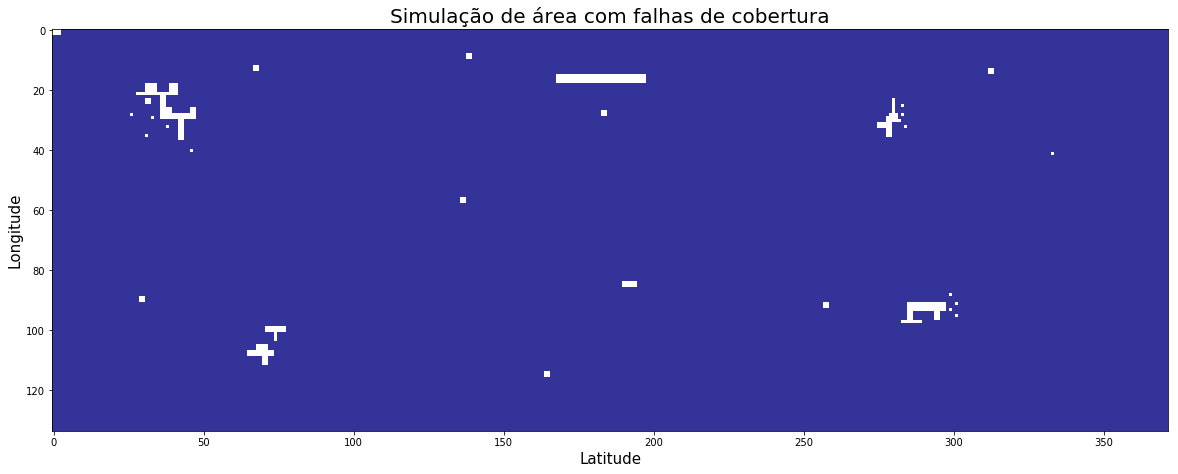

In [3]:
plt.figure(figsize=(20, 20))
plt.imshow(predicao, cmap=plt.cm.terrain)
plt.title("Simulação de área com falhas de cobertura", fontsize=20)
plt.xlabel("Latitude", fontsize=15)
plt.ylabel("Longitude", fontsize=15);

### Adequando o dataset
Para podermos trabalhar com o DBSCAN, necessitamos antes adequar o dataset ao padrão de entrada [x, y] exigido pelo algoritmo. No nosso caso serão os dados de latitude e longitude.

In [4]:
# Transformando o dataset em colunas lat, long e valor
temp = []
baseCol = []

# Transforma o dataset
linha = predicao.index
coluna = predicao.columns

for l in linha:
    for c in coluna:
        temp = [l, c, predicao.at[l, c]]
        baseCol.append(temp)

baseCol1 = pd.DataFrame(baseCol, columns=['Latitude', 'Longitude', 'Cobertura'])

baseCol1.head()   # Olhando as primeiras linhas

,Latitude,Longitude,Cobertura
0,1,1,NaN
1,1,2,NaN
2,1,3,NaN
3,1,4,1.0
4,1,5,1.0


Como queremos trabalhar somente com as falhas de cobertura, devemos filtrar somente os casos que apresentam o valor vazio (null).

In [5]:
# Filtrando a base somente com o clutters com falha de cobertura
baseCol2 = baseCol1[baseCol1.Cobertura != 1]

### Implementando o algoritmo
Vamos agora configurar os parâmetros do modelo e treiná-lo. Para o nosso exemplo, vamos definir que para ser considerado um cluster de falha de cobertura, necessitará ter ao menos 10 amostras com falha numa área total de 121 amostras (utilizando como distância 5). 

<img src="image/core_sample.png" width="350">

In [6]:
# Instancia e configura os parâmetros do DBSCAN
distancia = 5
amostras = 10

# Aplicando o modelo
clustering = DBSCAN(eps=distancia, min_samples=amostras).fit(baseCol2.iloc[ : , 0:2])

Após a classificação, o algoritmo gera o atributo ''labels_'' que nada mais é que a classificação dada a cada um dos cluster agrupados. 
Vamos anexar esse atributo ao dataset anterior para verificar como foi classificado cada um dos pontos.

**Nota:** Caso queira verificar cada um dos atributos gerados pelo algoritmo, há um link da documentação na seção Fontes e referencias, ao final do texto(7).

In [7]:
# Adicionando as classificações ao dataset
clusters = pd.DataFrame(clustering.labels_)   # Instancia os grupos classificados

baseCol3 = baseCol2.reset_index(drop=True)  # Reseta o indice
baseCol3['Cluster'] = clusters                 # Adiciona os grupos ao DataSet
baseCol3.tail(8)

,Latitude,Longitude,Cobertura,Cluster
380,111,71,NaN,5
381,111,72,NaN,5
382,112,71,NaN,5
383,112,72,NaN,5
384,115,165,NaN,-1
385,115,166,NaN,-1
386,116,165,NaN,-1
387,116,166,NaN,-1


Podemos ver no fragmento do dataset acima que foi adicionado uma categoria de cluster para cada um dos pontos relacionados. Os outliers, ou seja, áreas sem cobertura que não atenderam aos requisitos configurados nos parâmetros, foram marcados como grupo -1.

#### Plotando as falhas classificadas
Para visualizar como ficou a classificação do algoritmo, vamos plotar novamente o gráfico tematizando as falhas com a cor de cada cluster. Para isso, vamos criar um dataset no formato do original, apenas substituindo os valores de cobertura pelo valor de classificação dos clusters.

In [8]:
# Copia o mapa de predição
predicaoGrp = predicao.copy()

# Limpa os valores
predicaoGrp.replace(1, np.nan, inplace=True)

# Insere os grupos
linhas = np.arange(len(baseCol3.index))
for i in linhas:
    predicaoGrp.at[baseCol3.at[i, 'Latitude'], baseCol3.at[i, 'Longitude']] = baseCol3.at[i, 'Cluster']

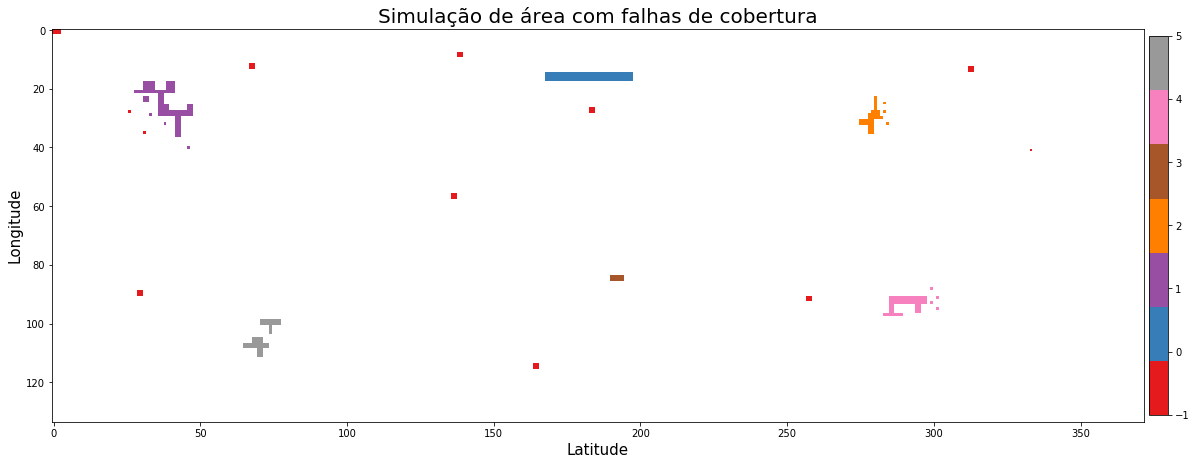

In [9]:
# Plotando o gráfico
plt.figure(figsize=(20, 20))
plt.imshow(predicaoGrp, cmap=plt.cm.get_cmap('Set1', 7))
plt.title("Simulação de área com falhas de cobertura", fontsize=20)
plt.xlabel("Latitude", fontsize=15)
plt.ylabel("Longitude", fontsize=15)
plt.colorbar(fraction=0.017, pad=0.005);

A plotagem acima é apenas para mostrar como o algoritmo classificou cada uma das falhas. Podemos verificar também as falhas de cobertura consideradas como outliers, marcadas como grupo -1, plotadas em vermelho.

### Definindo áreas prioritárias
A partir de cada área com a falha devidamente classificada, podemos rankear como prioridade a área de maior tamanho:

In [10]:
# Construindo um ranking por tamanho de falha de cobertura
ranking = baseCol3.groupby('Cluster').agg({'Cluster': 'count'}).rename(columns={'Cluster': 'Tamanho Cluster'})
ranking.sort_values('Tamanho Cluster', ascending=False)

,Tamanho Cluster
Cluster,
1,100
0,90
4,62
5,49
-1,41
2,36
3,10


Podemos ver no ranking acima que a maior área com falha de cobertura é a 1, plotada em roxo no gráfico anterior.

O tamanho da área pode ser uma boa métrica de prioridade, porém uma análise mais precisa poderia ser feita se cruzássemos com outras bases. Poderíamos, por exemplo, correlacioná-la com outras camadas de informação como demografia, densidade urbana, dados socioeconômicos, importância estratégica, indicadores de qualidade e desempenho, etc.
<img src="image/grid_overlay.gif">

##### Utilizando um layer de prioridade
Como simplificação vamos separar o mapa em 4 níveis de importância e correlacioná-lo com o mapa de falha de cobertura para finalmente classificarmos as prioridades. Os níveis irão de 1(baixa prioridade) à 4(alta prioridade).

<img src="image/priority.png">

In [11]:
# Carregando a dataset de prioridades
xlsx = pd.read_excel("base\Pred_fict_prority.xlsx")
priority = pd.DataFrame(xlsx)

In [12]:
# Transformando o dataset de prioridades em colunas lat, long e valor
temp = []
baseCol = []

# Transforma o dataset
linha = priority.index
coluna = priority.columns

for l in linha:
    for c in coluna:
        temp = [l, c, priority.at[l, c]]
        baseCol.append(temp)

priority1 = pd.DataFrame(baseCol, columns=['Latitude', 'Longitude', 'Prioridade'])

# Redefinindo o index da base de prioridades para lat e long
priority2 = priority1.set_index(['Latitude', 'Longitude'])

In [13]:
# Redefinindo o index da base de cobertura para lat e long
baseCol4 = baseCol3.set_index(['Latitude', 'Longitude'])

In [14]:
# Concatenando a base de cobertura com a base de prioridades
baseFinal = pd.concat([baseCol4, priority2], axis=1)
baseFinal.head()

Cobertura  Cluster  Prioridade
Latitude Longitude                                
1        1                NaN     -1.0         1.0
         2                NaN     -1.0         1.0
         3                NaN     -1.0         1.0
         4                NaN      NaN         1.0
         5                NaN      NaN         1.0

In [15]:
# Construindo um ranking por grau de importância do cluster
ranking['Prioridade Cluster'] = baseFinal.groupby('Cluster')['Prioridade'].sum().nlargest(10)
ranking.sort_values('Prioridade Cluster', ascending=False)

,Tamanho Cluster,Prioridade Cluster
Cluster,,
4,62,248.0
5,49,147.0
0,90,129.0
1,100,100.0
-1,41,74.0
2,36,72.0
3,10,40.0


Apesar de não possuir a maior área sem cobertura, o grupo 4 foi rankeado com maior prioridade, enquanto que o grupo 1, de maior tamanho, ficou em quarto lugar. Levando esse resultado à um exemplo prático, caso fosse solicitada uma priorização de investimento na região, mesmo sem conhecê-la muito bem, o engenheiro de RF poderia sugerir o grupo 4 fundamentado pela análise do algoritmo.

### Conclusão
Como dito no início do texto, o intuito desse artigo foi apresentar um método alternativo à inspeção visual de análise de falha de cobertura. O algoritmo DBSCAN se mostrou bastante eficaz à solução proposta. A seguir, os benefícios que pudemos observar:  
**Velocidade de análise** - Executar uma análise de cobertura de maneira visual pode ser fácil quando feita em um bairro ou uma cidade pequena, porém pode se tornar inviável se a área for muito grande. A automatização dessa atividade pode ser de grande valia.    
**Priorização através de dados mensuráveis** – Numa análise visual pode-se deparar com várias regiões com problemas de cobertura, tornando a priorização uma tarefa complexa. Utilizando o DBSCAN na clusterização das áreas sem cobertura, pudemos criar um ranking utilizando o tamanho da área e até mesmo ponderá-las com outras informações, diminuindo assim a subjetividade da análise.  
**Identificação de pequenas áreas sem cobertura (outliers)** – Na análise visual, pequenas áreas sem cobertura podem passar despercebidas, porém como o DBSCAN categoriza elementos que não atendam às premissas imputadas como outliers, poderíamos montar uma lista dessas áreas e atuar com soluções diferenciadas como utilização de small-cells ou até mesmo uma simples otimização dos sites existentes. 

Apesar de termos utilizado uma base fictícia, poderíamos ter utilizado uma base real e inclusive plotá-la em um mapa. Há alguns exemplos de como fazer isso na seção de Fontes e Referências(8)(9).

### Fontes e referências:  
#### Telecomunicações:  
(1)http://www.teleco.com.br/qsmc_reclamacoes.asp  
(2)https://www.siradel.com/software/connectivity/volcano-software/  
(3)http://blog.industrialnetworking.com/2014/04/making-sense-of-signal-strengthsignal.html  
(4)https://en.wikipedia.org/wiki/Received_signal_strength_indication  
(5)https://www.tim.com.br/sp/para-voce/cobertura-e-roaming/mapa-de-cobertura  

#### DBSCAN:  
(6)https://github.com/rdemarqui/Data-Science-Basico/blob/master/Python/05%20Scikit-learn/06.03.01%20DBSCAN%20-%20Introdu%C3%A7%C3%A3o.ipynb  
(7)https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html  
(8)http://qingkaikong.blogspot.com/2016/08/clustering-with-dbscan.html  
(9)https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/  